
=== Model Performance ===

SVC Metrics:
              precision    recall  f1-score   support

        FAKE       1.00      0.99      1.00      1178
        REAL       0.99      1.00      1.00      1178

    accuracy                           1.00      2356
   macro avg       1.00      1.00      1.00      2356
weighted avg       1.00      1.00      1.00      2356



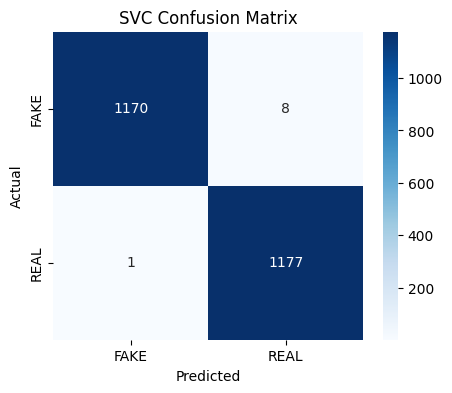


Naive Bayes Metrics:
              precision    recall  f1-score   support

        FAKE       0.81      0.86      0.83      1178
        REAL       0.85      0.80      0.82      1178

    accuracy                           0.83      2356
   macro avg       0.83      0.83      0.83      2356
weighted avg       0.83      0.83      0.83      2356



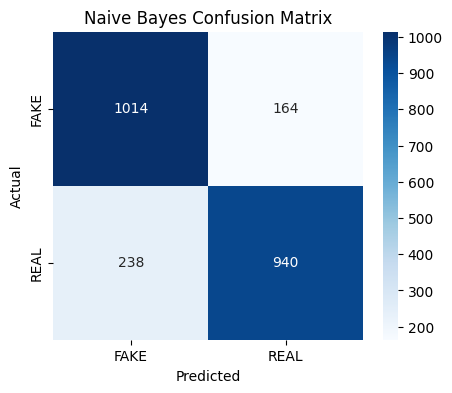


KNN Metrics:
              precision    recall  f1-score   support

        FAKE       1.00      0.99      0.99      1178
        REAL       0.99      1.00      0.99      1178

    accuracy                           0.99      2356
   macro avg       0.99      0.99      0.99      2356
weighted avg       0.99      0.99      0.99      2356



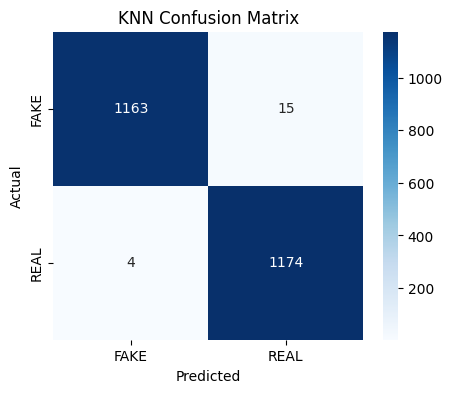


Random Forest Metrics:
              precision    recall  f1-score   support

        FAKE       0.99      0.99      0.99      1178
        REAL       0.99      0.99      0.99      1178

    accuracy                           0.99      2356
   macro avg       0.99      0.99      0.99      2356
weighted avg       0.99      0.99      0.99      2356



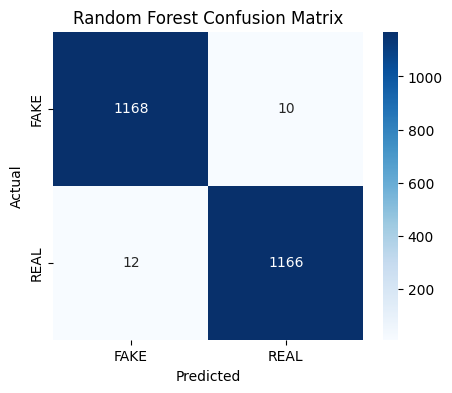


=== Precision-Recall and ROC Curves ===


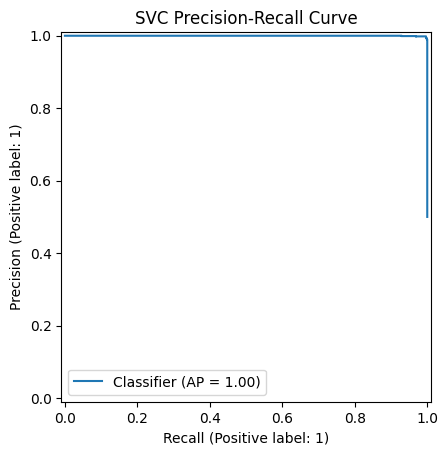

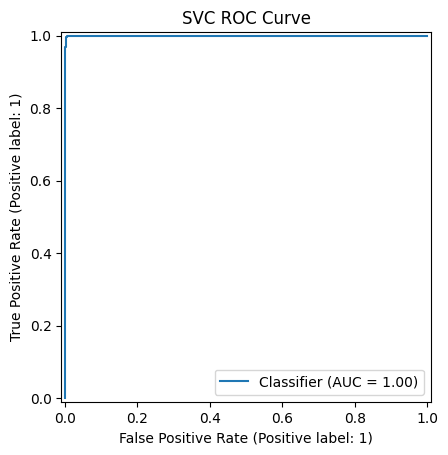

SVC AUC-ROC: 0.9999


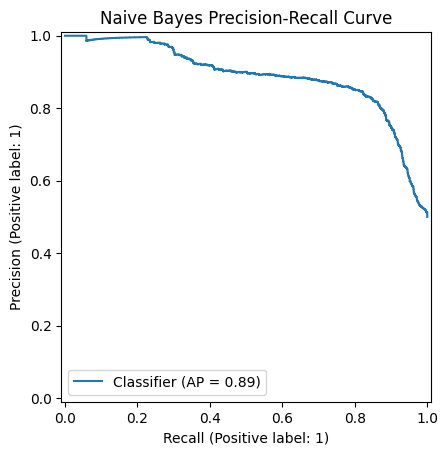

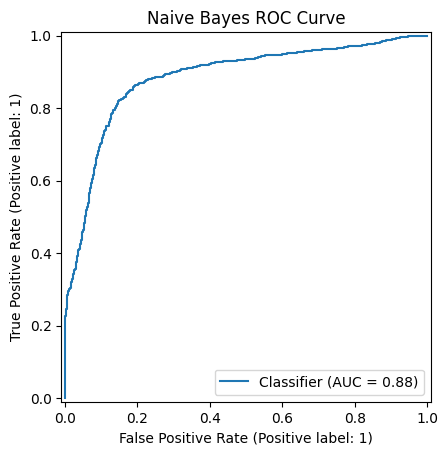

Naive Bayes AUC-ROC: 0.8840


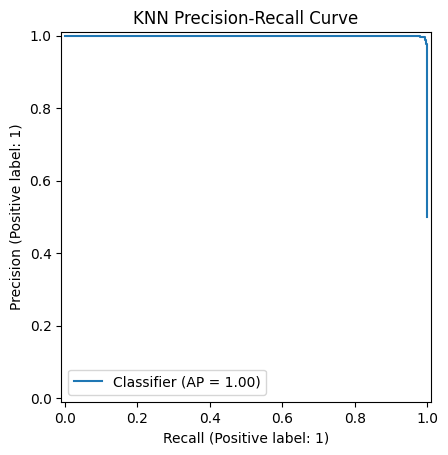

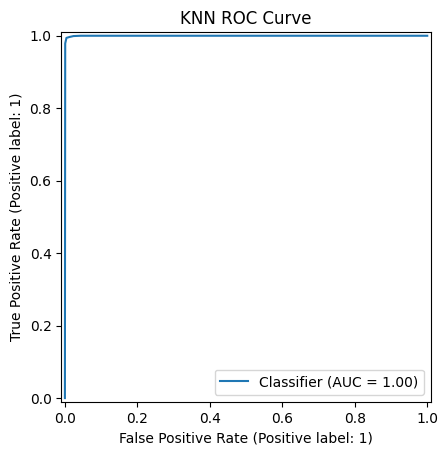

KNN AUC-ROC: 0.9994


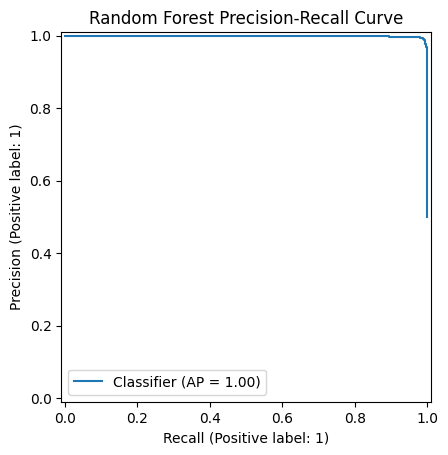

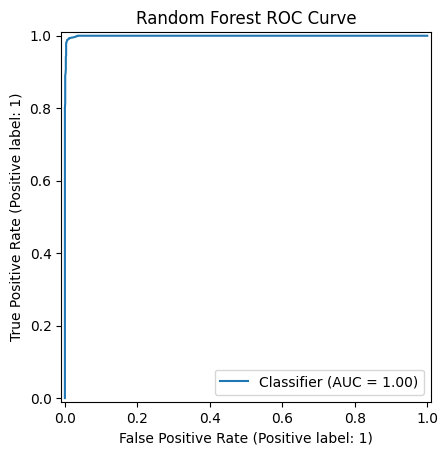

Random Forest AUC-ROC: 0.9994

=== Cross-Validation Scores ===
SVC Cross-Validation Accuracy: Mean = 0.9949, Std = 0.0021
Naive Bayes Cross-Validation Accuracy: Mean = 0.8205, Std = 0.0070
KNN Cross-Validation Accuracy: Mean = 0.9934, Std = 0.0014
Random Forest Cross-Validation Accuracy: Mean = 0.9873, Std = 0.0020

=== Feature Importance ===

SVC Feature Importance:
   Feature  Importance
17  mfcc12    0.042190
1      rms    0.031749
9    mfcc4    0.030306
7    mfcc2    0.025127
14   mfcc9    0.018251


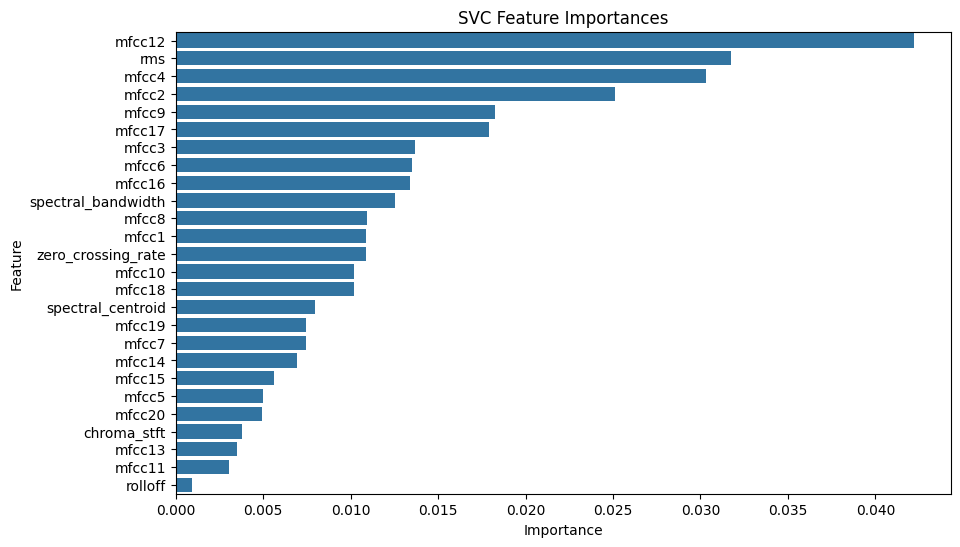


Naive Bayes Feature Importance:
               Feature  Importance
23              mfcc18    0.024873
3   spectral_bandwidth    0.022750
7                mfcc2    0.018166
14               mfcc9    0.015705
13               mfcc8    0.013837


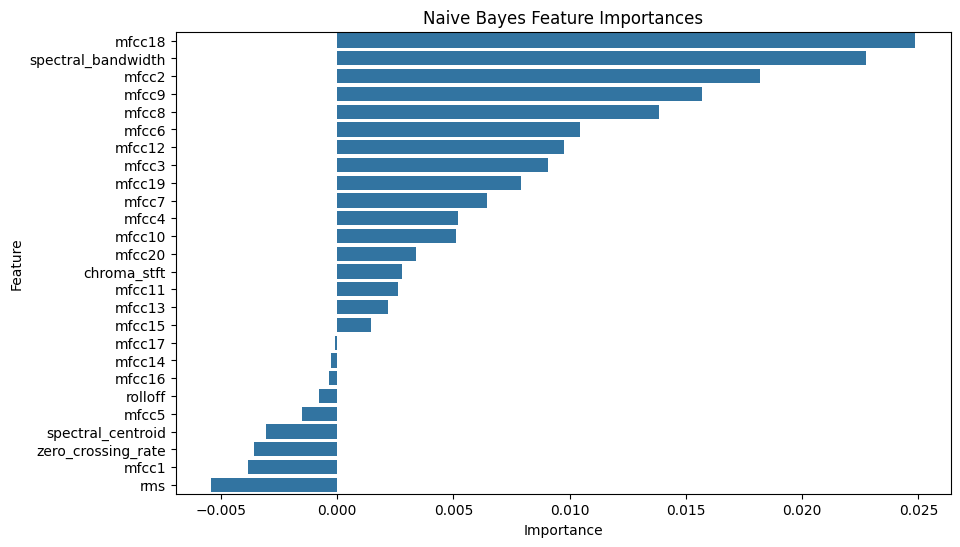


KNN Feature Importance:
   Feature  Importance
17  mfcc12    0.014346
1      rms    0.011800
6    mfcc1    0.008065
9    mfcc4    0.007555
23  mfcc18    0.006791


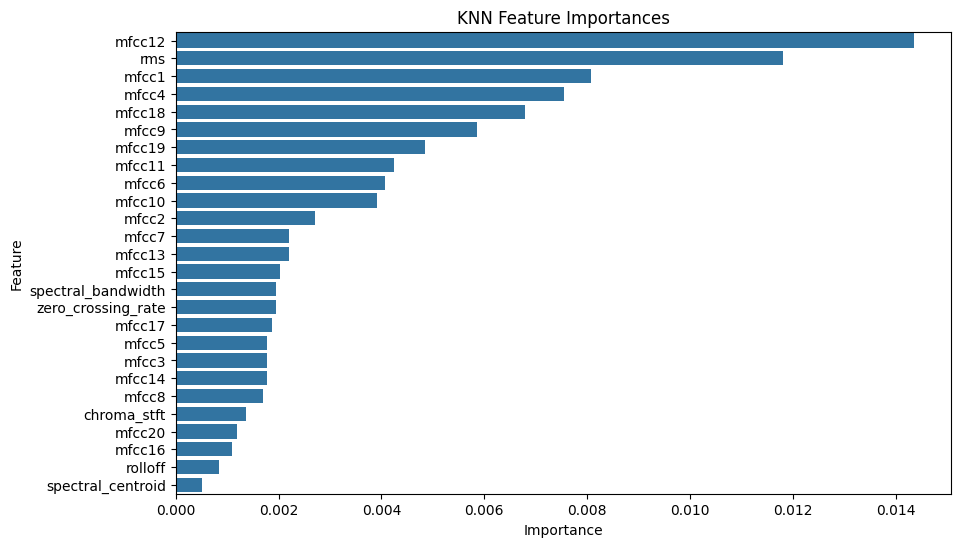


Random Forest Feature Importance:
   Feature  Importance
7    mfcc2    0.103879
23  mfcc18    0.063699
17  mfcc12    0.061186
13   mfcc8    0.058019
14   mfcc9    0.055268


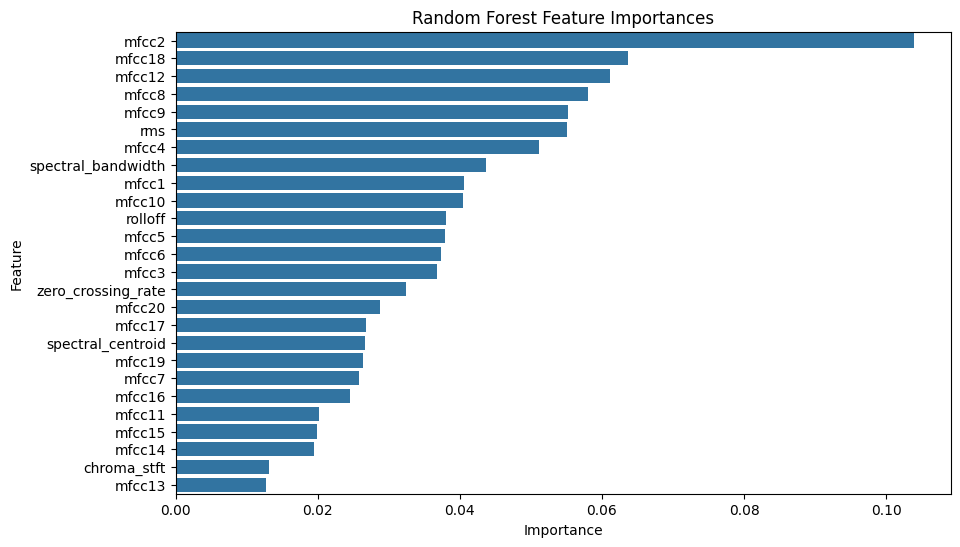

In [2]:
# Required Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    RocCurveDisplay,
    PrecisionRecallDisplay,
)
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Load and Prepare Data
# put location of dataset here
data = pd.read_csv('/content/drive/MyDrive/KAGGLE/DATASET-balanced.csv')

# Encode Labels: FAKE -> 0, REAL -> 1
label_encoder = LabelEncoder()
data['LABEL'] = label_encoder.fit_transform(data['LABEL'])

# Separate Features and Labels
X = data.drop(columns=['LABEL'])
y = data['LABEL']

# Normalize Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split Data: Train/Test (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Step 2: Define Models
models = {
    'SVC': SVC(probability=True, random_state=42),  # Enable probability for ROC/PR curves
    'Naive Bayes': GaussianNB(),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Random Forest': RandomForestClassifier(random_state=42),
}

# Train Models
for name, model in models.items():
    model.fit(X_train, y_train)

# Step 3: Evaluate Model Performance
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=['FAKE', 'REAL'],
        yticklabels=['FAKE', 'REAL'],
    )
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

print("\n=== Model Performance ===")
for name, model in models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    # Print Metrics
    print(f"\n{name} Metrics:")
    print(classification_report(y_test, y_pred, target_names=['FAKE', 'REAL']))

    # Plot Confusion Matrix
    plot_confusion_matrix(cm, title=f'{name} Confusion Matrix')

# Step 4: Precision-Recall and ROC Curves
print("\n=== Precision-Recall and ROC Curves ===")
for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = model.decision_function(X_test)

    # Plot Precision-Recall Curve
    PrecisionRecallDisplay.from_predictions(y_test, y_proba)
    plt.title(f'{name} Precision-Recall Curve')
    plt.show()

    # Plot ROC Curve
    RocCurveDisplay.from_predictions(y_test, y_proba)
    plt.title(f'{name} ROC Curve')
    plt.show()

    # Print AUC-ROC
    auc = roc_auc_score(y_test, y_proba)
    print(f"{name} AUC-ROC: {auc:.4f}")

# Step 5: Cross-Validation
print("\n=== Cross-Validation Scores ===")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for name, model in models.items():
    scores = cross_val_score(model, X_scaled, y, cv=cv, scoring='accuracy')
    print(f"{name} Cross-Validation Accuracy: Mean = {scores.mean():.4f}, Std = {scores.std():.4f}")

# Step 6: Feature Importance
print("\n=== Feature Importance ===")
for name, model in models.items():
    print(f"\n{name} Feature Importance:")
    if hasattr(model, "feature_importances_"):  # For models like Random Forest
        feature_importances = model.feature_importances_
        importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
        importance_df = importance_df.sort_values(by='Importance', ascending=False)
    else:
        # Use permutation importance for models without intrinsic feature importance
        perm_importance = permutation_importance(model, X_test, y_test, scoring='accuracy', random_state=42)
        importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': perm_importance.importances_mean})
        importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Print Top Features
    print(importance_df.head())

    # Plot Feature Importances
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title(f'{name} Feature Importances')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()
